In [5]:
import os
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
results_folder = 'results'
figures_folder = 'figures'

# Find all files starting with 'FOXP3'
files = glob.glob(os.path.join(results_folder, '*.pkl'))

# Initialize lists to store ATE and GBF data
ate_data = []
gbf_data = []

# Load the data from the files
for file in files:
    with open(file, 'rb') as f:
        data = pickle.load(f)
        if 'ate_summary' in file:
            ate_data.append((file, data))
        elif 'gbf' in file:
            gbf_data.append((file, data))

# Plot ATE figures
for file, ate_summary in ate_data:
    sample_sizes = list(ate_summary.keys())
    ate_med = [np.median(ate_summary[size]) for size in sample_sizes]
    ate_lower = [np.percentile(ate_summary[size], 2.5) for size in sample_sizes]
    ate_upper = [np.percentile(ate_summary[size], 97.5) for size in sample_sizes]

    # Extract gene names from the file name
    base_name = os.path.basename(file)
    target_gene = base_name.split('_')[1]
    cause_gene = base_name.split('_')[0]
    plt.figure(figsize=(4, 4))
    plt.plot(sample_sizes, ate_med, marker='o', linestyle='-', color='blue', label="Median")
    plt.fill_between(sample_sizes, ate_lower, ate_upper, color='blue', alpha=0.2, label="95% CI")
    plt.title('ATE Summary', fontsize=16)
    plt.xlabel('n', fontsize=16)
    plt.ylabel('ATE Value', fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(figures_folder, f'ATE_summary_{cause_gene}_{target_gene}.pdf'), dpi=300)
    plt.show()

# Plot GBF figures
for file, gbf_summary in gbf_data:
    sample_sizes = list(gbf_summary.keys())
    median_gbf = [np.median(gbf_summary[size]) for size in sample_sizes]
    lower_ci = [np.percentile(gbf_summary[size], 2.5) for size in sample_sizes]
    upper_ci = [np.percentile(gbf_summary[size], 97.5) for size in sample_sizes]

    # Extract gene names from the file name
    base_name = os.path.basename(file)
    target_gene = base_name.split('_')[1]
    cause_gene = base_name.split('_')[0]
    plt.figure(figsize=(4, 4))
    plt.plot(sample_sizes, median_gbf, marker='o', linestyle='-', color='blue', label='Median')
    plt.fill_between(sample_sizes, lower_ci, upper_ci, color='blue', alpha=0.2, label='95% CI')
    plt.xlabel('n', fontsize=16)
    plt.ylabel('Generalized Mixing Weight', fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(figures_folder, f'gbf_{cause_gene}_{target_gene}.pdf'), dpi=300)
    plt.show()

## Diagnostic Plots

In [2]:
from transformer import test_run
from modeling_util import causal_lm, causal_BART

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(


In [3]:
a, y, X_hat, X = test_run(cause_gene='FOXP3', target_gene='GZMH')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Return:
a - Expression levels of the cause gene
y - Expression levels of the target gene
testX_hat - Low-dimensional embedding of the confounding genes
testX - Original expression levels of the confounding genes

In [6]:
n_obs = len(a)
n_post = 1000
q98_a = np.percentile(a, 98)
q0_a = np.percentile(a, 0)

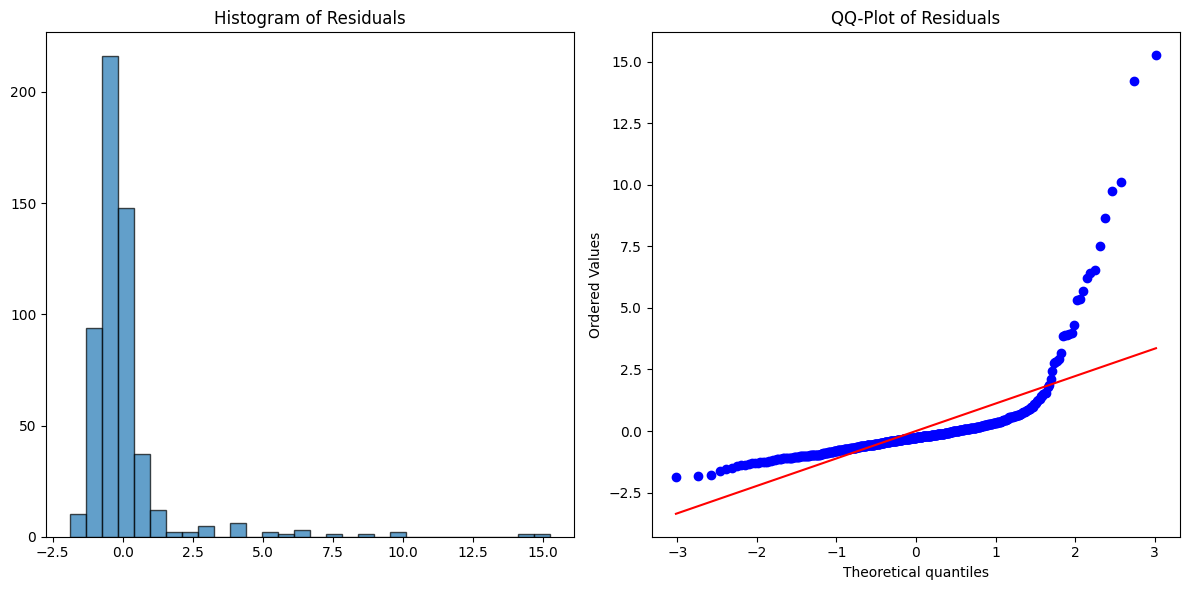

Posterior mean of ATE: -0.24960485511280012
Posterior standard deviation of ATE: 0.21472023381761557
95% credible interval for ATE: [-0.6704565133953266, 0.1712468031697264]
R-squared: 0.1077009284544529
Adjusted R-squared: 0.08925113562174425


In [7]:
ate_pm = causal_lm(X_hat, a, y, q98_a, q0_a,"FOXP3","GZMH",n_post, plot_diagonostics = True)

In [ ]:
ate_np = causal_BART(X, a, y, q98_a, q0_a,"FOXP3","GZMH", n_post = n_post, n_samples_per_trace=30, n_BB=1000, trace_plot = True)